# ML: Predicting Star Ratings


In this project, the objective is to predict a new venue's popularity from information available when the venue opens.  We will need to build a machine learning algorism from a dataset of venue popularities provided by Yelp.  The dataset contains meta data about the venue (where it is located, the type of food served, etc.) and the star ratings. 
*Note that the venues are not limited to restaurants.


In [1]:
import seaborn as sns
sns.set()

### Parse the data

The dataset is private and not shared. The training data are a series of JSON objects, in a Gzipped file. The built-in `json` package has a `loads` function that converts a JSON string into a Python dictionary.

In [2]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In scikit-learn, the labels to be predicted, in this case, the stars, are always kept in a separate data structure than the features.

In [3]:
star_ratings = [row['stars'] for row in data]

In [5]:
data[0] # an example that shows the format of the data

{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA',
 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018',
 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'},
  'Friday': {'close': '17:00', 'open': '08:00'},
  'Monday': {'close': '17:00', 'open': '08:00'},
  'Wednesday': {'close': '17:00', 'open': '08:00'},
  'Thursday': {'close': '17:00', 'open': '08:00'}},
 'open': True,
 'categories': ['Doctors', 'Health & Medical'],
 'city': 'Phoenix',
 'review_count': 7,
 'name': 'Eric Goldberg, MD',
 'neighborhoods': [],
 'longitude': -111.983758,
 'state': 'AZ',
 'stars': 3.5,
 'latitude': 33.499313,
 'attributes': {'By Appointment Only': True},
 'type': 'business'}

In [7]:
print(len(star_ratings), len(data))

37938 37938


## Model 1: the lat_long model

It is reasonable to believe that some neighborhoods are trendier than others.  Use the latitude and longitude of a venue as features that help us understand neighborhood dynamics.

Since we need to select the appropriate columns from the dictionaries to build our latitude-longitude model, we will have to use scikit-learn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html). However, the `ColumnTransformer` works with either NumPy arrays or pandas data frames. In this case, a transformer was built to convert a list of dictionaries into a pandas data frame.

In [36]:
import pandas as pd
from sklearn.base import BaseEstimator,TransformerMixin, RegressorMixin

class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # The transformer doesn't need to learn anything about the data,so it can just return self
        return self
    
    def transform(self, X):
        # Return a pandas data frame from X
        return pd.DataFrame(X)

In [10]:
import numpy as np
from sklearn.compose import ColumnTransformer

# Instantiate a ColumnTransformer
selector = ColumnTransformer([('location', ToDataFrame(), ['latitude', 'longitude'])], remainder = 'drop')

We will use a pipeline, ensuring that our model applies all the required transformations given the form of the input data. And we feed the output of the transformer in to a `KNeighborsRegressor`.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

pipe = Pipeline([('dataframe', ToDataFrame()),('location', selector),('regressor', KNeighborsRegressor())])

The `KNeighborsRegressor` takes the `n_neighbors` hyperparameter, which tells it how many nearest neighbors to average together when making a prediction. We will need to determine an optimal value for this hyperparameter. A common approach is to use a hyperparameter searching tool such as [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV).

But before that, we must consider whether the data needs to be shuffled as it might not have been randomized. For example, the data could be ordered by a certain feature or by the labels. 
We can check that by plotting a rolling mean of the star ratings. Seems that we need to shuffle the data.

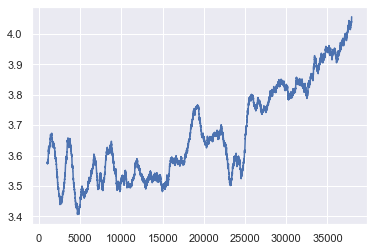

In [14]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(star_ratings), window=1000).mean());

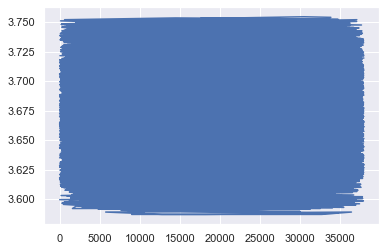

In [17]:
# Data shuffling
data_df = pd.DataFrame(data)
data_df_shuffled = data_df.sample(frac = 1)
plt.plot(Series.rolling((data_df_shuffled[['stars']]), window=1000).mean());

In [21]:
from sklearn.model_selection import GridSearchCV

grid_params = {
                'n_neighbors': [69,75,81,87],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
}

gs = GridSearchCV(
                KNeighborsRegressor(),
                grid_params,
                verbose = 1,
                n_jobs = -1
)

y = data_df_shuffled[['stars']]
X = data_df_shuffled[['latitude','longitude']]
gs_results = gs.fit(X,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [22]:
# Find the best n_neighbors parameter
gs_results.best_score_, gs_results.best_estimator_, gs_results.best_params_

(0.021067822071598206,
 KNeighborsRegressor(metric='manhattan', n_neighbors=75),
 {'metric': 'manhattan', 'n_neighbors': 75, 'weights': 'uniform'})

In [23]:
lat_long_model = Pipeline([
                        ('dataframe', ToDataFrame()),
                        ('location', selector),
                        ('regressor', KNeighborsRegressor(n_neighbors=75, metric='manhattan'))
])
lat_long_model.fit(data, star_ratings)

Pipeline(steps=[('dataframe', ToDataFrame()),
                ('location',
                 ColumnTransformer(transformers=[('location', ToDataFrame(),
                                                  ['latitude', 'longitude'])])),
                ('regressor',
                 KNeighborsRegressor(metric='manhattan', n_neighbors=75))])

In [24]:
lat_long_model.score(data, star_ratings)

0.04944401968538237

## Model 2: the Category model

Apparently, while location and neighborhood is important, the prediction based on the single feature is not satisfying. We should also try seeing how predictive the venue's category is.


The categories come as a list of strings, but the scikit-learn's predictors all need numeric input. We ultimately want to create a column in our feature matrix to represent every category. For a given row, only the columns that represent the categories it contains will be filled with a one, otherwise, it will be filled with a zero. The described method is similar to `OneHotenEoding`, however, an observation/row can contain more than one "hot", non-zero, column.

To achieve our encoding plan, we need to use scikit-learn's provided [`DictVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer). This transformer takes a 1-D array of dictionaries and creates a column in the output matrix for each key in the dictionary and fills it with the value associated with it. Missing keys are filled with zeros. Therefore, we need to build a transformer that takes an array of strings and returns an array of dictionaries with keys given by those strings and values of one.

In [25]:
from collections import Counter

class DictEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series. Return a pandas series of dictionaries
        X_list = [dict(Counter(x)) for x in X]
        return pd.Series(X_list)

Now, create a pipeline object of the two step transformation for the categories data. Afterwards, create a `ColumnTransformer` object that will use the aforementioned pipeline object to transform the `'categories'` field.

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer

cat_pipe = Pipeline([('encoder', DictEncoder()),('vectorizer', DictVectorizer())])

cat_transformer = ColumnTransformer([('categories', cat_pipe, 'categories')], remainder = 'drop')

Finally, create a pipeline object that will
1. Convert the list of dictionaries into a data frame
2. Select the `'categories'` column and encode the data
3. Add in a [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) between the `DictVectorizer` and the linear model to measure term frequency-inverse document frequency (tf-idf)
4. Train a regularized linear model such as `Ridge`

There will be a large number of features, one for each category, so there is a significant danger of overfitting. Cross validation is used to choose the best regularization parameter.

In [28]:
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV

cat_transform_fit = Pipeline([
                            ('df',ToDataFrame()),
                            ('encodecat',cat_transformer),
                            ('frequency',TfidfTransformer()),
                            ('ridge',Ridge())
                            ])

category_model = GridSearchCV(cat_transform_fit, {'ridge__alpha':[1,5,10,20]}, cv = 5, n_jobs = -1)

category_model.fit(data, star_ratings)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('df', ToDataFrame()),
                                       ('encodecat',
                                        ColumnTransformer(transformers=[('categories',
                                                                         Pipeline(steps=[('encoder',
                                                                                          DictEncoder()),
                                                                                         ('vectorizer',
                                                                                          DictVectorizer())]),
                                                                         'categories')])),
                                       ('frequency', TfidfTransformer()),
                                       ('ridge', Ridge())]),
             n_jobs=-1, param_grid={'ridge__alpha': [1, 5, 10, 20]})

In [29]:
category_model.best_params_, category_model.best_score_

({'ridge__alpha': 5}, 0.14036180446374213)

In [31]:
category_model.score(data, star_ratings) # Better score than the above lat_long model that is based on neighborhood feature

0.20487676212005712

## Model 3: the Attribute model

There is even more information in the attributes for each venue.  Now let's build an estimator based on these attributes.

Venues attributes may be nested:
```python
{
  'Attire': 'casual',
  'Accepts Credit Cards': True,
  'Ambiance': {'casual': False, 'classy': False}
}
```
Again, we want to encode them in the same manner as our categories data using the `DictVectorizer`. Before we do so, we need to flatten the dictionary to a single level:
```python
{
  'Attire_casual' : 1,
  'Accepts Credit Cards': 1,
  'Ambiance_casual': 0,
  'Ambiance_classy': 0
}
```
First, we need to build a custom transformer that flattens the dictionary for the `'attributes'` field.

In [32]:
def bool_or_str (key, value):
    if value == False:
        new_key = 0
    elif value == True:
        d[key] = 1
    else:
        new_key = str(key)+'_'+str(value)
        d[new_key] = 1
    return key,

In [33]:
def flatten_out (nested, parentKey = ""):
    l = []
    for x in nested:
        for key, value in x.items():
            if isinstance(value, dict):
                return flatten_out(value, str(key))
            else:
                l.append(bool_or_str(parentKey+str(key), value))
    return l

In [34]:
# Create the transformer to flatten out the attributes data and pass into the DictVectorizer
class attributesEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series. Return a pandas series of dictionaries
        l = []
        for x in X:
            d = dict()
            for key,value in x.items():
                if type(value) != dict:
                    if value == False:
                        d[key] = 0
                    elif value == True:
                        d[key] = 1
                    else:
                        new_key = str(key)+'_'+str(value)
                        d[new_key] = 1
                else:
                    for sub_key, sub_value in value.items():
                        new_key = str(key)+'_'+str(sub_key)
                        if sub_value == False:
                            d[new_key] = 0
                        elif sub_value == True:
                            d[new_key] = 1
                        else:
                            sub_new_key = new_key+'_'+str(sub_value)
                            d[sub_new_key] = 1
            l.append(d)
        return pd.Series(l)

attr_pipe = Pipeline([('encoder', attributesEncoder()),('vectorizer', DictVectorizer())])

attr_transformer = ColumnTransformer([('attr_vectorize', attr_pipe, 'attributes')], remainder = 'drop')

It is difficult to find a single regressor that performs well enough. A common solution is to use a linear model to fit the linear part of some data, and use a non-linear model to fit the residual that the linear model can't fit.

In [86]:
# Create the linear + non-linear combo predictor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

class comboPredictor (BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.linear = Ridge(alpha=2) # The alpha parameter was optimized using GridSearchCV
        self.decisiontree = DecisionTreeRegressor(max_depth = 10) # DecisionTreeRegressor is used to fit the non-linear part
        
    def fit(self, X, y):
        self.linear.fit(X, y)
        residue = y - self.linear.predict(X)
        self.decisiontree.fit(X, residue)
        return self
    
    def predict(self, X):
        return self.linear.predict(X) + self.decisiontree.predict(X)
    
# Create the attribute model
attribute_model = Pipeline([
                            ('df',ToDataFrame()),
                            ('encodeAttr',attr_transformer),
                            ('frequency',TfidfTransformer()),
                            ('regressor',comboPredictor())
                            ])

attribute_model.fit(data, star_ratings)

Pipeline(steps=[('df', ToDataFrame()),
                ('encodeAttr',
                 ColumnTransformer(transformers=[('attr_vectorize',
                                                  Pipeline(steps=[('encoder',
                                                                   attributesEncoder()),
                                                                  ('vectorizer',
                                                                   DictVectorizer())]),
                                                  'attributes')])),
                ('frequency', TfidfTransformer()),
                ('regressor', comboPredictor())])

In [87]:
attribute_model.score(data, star_ratings)

0.10225240110227851

## The full model

So far we have only built models based on individual features.  Now we will build an ensemble regressor that combines the estimates of the three previous regressors.

In order to use the existing models as input to a predictor, we will have to turn them into transformers; a predictor can only be in the final step of a pipeline. Build a custom `ModelTransformer` class that takes a predictor as an argument. When `fit` is called, the predictor should be fit. When `transform` is called, the predictor's `predict` method should be called, and its results returned as the transformation.

Note that the output of the `transform` method should be a 2-D array with a single column in order for it to work well with the scikit-learn pipeline. If you're using NumPy arrays, you can use `.reshape(-1, 1)` to create a column vector.

In [72]:
class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        # Fit the stored predictor.
        self.model.fit(X, y)
        return self
    
    def transform(self, X):
        # Use predict on the stored predictor as a "transformation".
        # Need to return a 2-D array.
        return np.array(self.model.predict(X)).reshape(-1,1)

Create an instance of `ModelTransformer` for each of the previous four models. Combine these together in a single feature matrix with a
[`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion).

In [73]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([('lat_long_trans', ModelTransformer(lat_long_model)),
                      ('category_trans', ModelTransformer(category_model)),
                      ('attribute_trans', ModelTransformer(attribute_model))
        # FeatureUnion uses the same syntax as Pipeline
    ])

Finally, use a pipeline to combine the feature union with `RandomForestRegressor` to weight the predictions.

In [99]:
from sklearn.ensemble import RandomForestRegressor

full_model = Pipeline([('union', union),
                       ('regressor', RandomForestRegressor())]) 
full_model.fit(data, star_ratings)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('lat_long_trans',
                                                 ModelTransformer(model=Pipeline(steps=[('dataframe',
                                                                                         ToDataFrame()),
                                                                                        ('location',
                                                                                         ColumnTransformer(transformers=[('location',
                                                                                                                          ToDataFrame(),
                                                                                                                          ['latitude',
                                                                                                                           'longitude'])])),
                                                    

In [100]:
full_model.score(data, star_ratings) # Significantly improved prediction power with the ensembled model

0.8195016028161191